# Community detection

Algorithm solves community detection problem of undirected graph $G = (V, E)$ where every edge there has weight $w_{ij}$.

Algorithm was developed based on modularity approach (https://journals-aps-org.libproxy.helsinki.fi/pre/pdf/10.1103/PhysRevE.70.056131), where task is to minimize funcion $Q=\dfrac{1}{2m} \sum_{ij}(-A_{ij}+\dfrac{k_ik_j}{2m}) \delta (c_i,c_j)$, where $k$ is sum of weights of edges which connects to vertex, $c$ is the community of vertex and $A_{ij} = w_{xy}$. This function describes the modularity of given graph.

Length of binary variable vector is $|V||C|$ which elements are $(v \in V, c \in C)$ pairs. These elements of the vector indicates to which community each vertex belongs to.

Following contraints are implemented to QUBO, where penalty $p=\sum w_{xy}$: 
1. Vertex can belong to only one community (penalty $p$ for every couple of same vertices which are placed in different communities) 
2. Minimize modularity by giving penalty/gain of $(-A_{ij}+\dfrac{k_ik_j}{2m})$ to each $(v \in V, c \in C)$ pairs. 

Result of the algorithm is the lowest energy state of sample set. Binary variable vector indicates 
$(v \in V, c \in C)$ pairs, so assigning a community to each vertex. 

There are two limitations in this algorithm. Maximum number of communities must be defined a priori. Secondly number of elements in QUBO matrx can be rather large if there are many communities ($|V|^2|C|^2$). QUBO matrix is also rather sparse, there are diagnonal elements and $|C||V|(|V|+1)/2$ elements in upper diagonal. There may be more efficient algorithm in terms of the size of  binary variable vector.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import random
import dimod
from dwave.system import DWaveSampler, EmbeddingComposite, LeapHybridSampler
from dwave.samplers import SimulatedAnnealingSampler
import dwave.inspector
import networkx as nx
from networkx.classes.function import path_weight

## QUBO function

In [2]:
def create_qubo(G, communities, p):
    vertices = len(G.nodes)
    Q = np.zeros((vertices*communities, vertices*communities))
    
    # Helper datastructure to containt k
    k = np.zeros(vertices)
    for e in G.edges:
        k[e[0]] += G[e[0]][e[1]]['weight']
        k[e[1]] += G[e[0]][e[1]]['weight']

    # Constraint 1
    for v in range(vertices): 
        for c1 in range(communities): 
            Q[v*communities+c1,v*communities+c1] -= p
            for c2 in range(c1+1,communities):
                Q[v*communities+c1,v*communities+c2] += 2*p
                
    # Constraint 2
    for c in range(communities):
        for v1 in range(vertices): 
            for v2 in range(v1+1,vertices): 
                Q[v1*communities+c, v2*communities+c] += k[v1]*k[v2] / (2*p)
                
    for e in G.edges:
        for c in range(communities):
            Q[e[0]*communities+c, e[1]*communities+c] -= G[e[0]][e[1]]['weight']
            
    return Q

## Helper functions

In [3]:
def print_graph(G, pos=None, node_color=None, fig_size=6):
    if pos==None:
        pos = nx.get_node_attributes(G, 'pos')
    m = 0
    for k,v in nx.get_edge_attributes(G, 'weight').items():
        m = max(m,v)
    a = [v/m for k,v in nx.get_edge_attributes(G, 'weight').items()]
    plt.figure(figsize=(fig_size, fig_size))
    nx.draw_networkx_edges(G, pos, alpha=a)
    nx.draw_networkx_nodes(G, pos, node_size=80, node_color=node_color)
    plt.axis("off")
    plt.show()
    
colors=['gray', 'blue','red','green','magenta','yellow','purple','black']

def result_to_colors(G, sample):
    cs = np.zeros(len(G.nodes))
    for k,v in sample.items():
        if v==1: 
            cs[k[0]]=k[1]+1
    nc = []
    for i in range(len(cs)):
        nc.append(colors[int(cs[i])])
    return nc

def create_community_graph(vertices,communities):
    G = nx.Graph()
    vpc = int(vertices/communities)
    lo = vertices-vpc*communities
    index = 0
    c0 = []
    G.add_nodes_from([x for x in range(vertices)])
    for i in range(communities):
        if lo>0:
            c = vpc+1
            lo -= 1
        else:
            c = vpc
        for j in range(c-1):
            for k in range(j+1,c):
                G.add_weighted_edges_from([(index + j,index + k, 5)])
        c0.append(index)
        index += c
    for i in range(communities-1):
        for j in range(i+1,communities):
            G.add_weighted_edges_from([(c0[i],c0[j], 1)])
            G.add_weighted_edges_from([(c0[i]+1,c0[j]+1, 1)])
    return G

## Small example

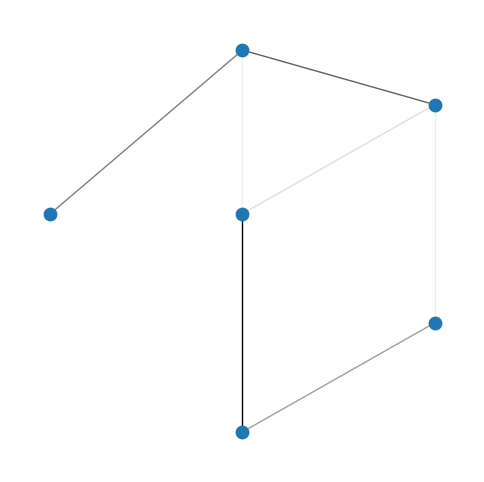

In [4]:
def simple_graph():
    E = np.array([(0, 2, 1), (1, 2, 2), (1, 3, 1), (0, 5, 8), (0, 1, 10), (3, 4, 6), (2, 4, 16)])
    V = [(0,dict(pos=(0.5,0.8))), (1,dict(pos=(0.8,0.7))), (2,dict(pos=(0.5,0.5))), (3,dict(pos=(0.8,0.3))), (4,dict(pos=(0.5,0.1))), (5,dict(pos=(0.2,0.5)))]
    G = nx.Graph()
    G.add_nodes_from(V)
    for e in E:
        G.add_edge(e[0], e[1], weight=e[2])
    return G

G = simple_graph()
communities = 2
print_graph(G)

![](graph1.png)

In [5]:
max_count = 0
for e in G.edges:
    max_count += G[e[0]][e[1]]['weight']
print('Max count:',max_count)

labels = {}
for i in range(len(G.nodes)):
    for j in range(communities):
        labels[i*communities + j]=(i,j)

Max count: 44


### Create QUBO and BQM

In [6]:
ts = time.time()
Q = create_qubo(G, communities, max_count)
qubo_time = (time.time()-ts)*1000
print('Time used for construction Q (ms): {:.3f}\n'.format(qubo_time))

ts = time.time()
bqm = dimod.BinaryQuadraticModel(Q, 'BINARY')
bqm_time = (time.time()-ts)*1000
bqm = bqm.relabel_variables(labels, inplace=False)

Time used for construction Q (ms): 0.276



In [7]:
print(dimod.generators.combinations(['a','b','c'],1))


BinaryQuadraticModel({'a': -1.0, 'b': -1.0, 'c': -1.0}, {('b', 'a'): 2.0, ('c', 'a'): 2.0, ('c', 'b'): 2.0}, 1.0, 'BINARY')


### Exact solver

In [8]:
ts = time.time()
sampleset = dimod.ExactSolver().sample(bqm)
det_time = (time.time()-ts)*1000
print('Time used (ms): {:.3f}\n'.format(det_time))
energy = sampleset.first.energy
print(sampleset.truncate(20))

Time used (ms): 10.489

   (0, 0) (0, 1) (1, 0) (1, 1) (2, 0) (2, 1) ... (5, 1)      energy num_oc.
0       0      1      0      1      1      0 ...      1 -290.272727       1
1       1      0      1      0      0      1 ...      0 -290.272727       1
2       0      1      0      1      1      0 ...      1 -285.352273       1
3       1      0      1      0      0      1 ...      0 -285.352273       1
4       1      0      1      0      0      1 ...      1 -280.818182       1
5       0      1      0      1      1      0 ...      0 -280.818182       1
6       1      0      0      1      0      1 ...      0 -280.170455       1
7       0      1      1      0      1      0 ...      1 -280.170455       1
8       1      0      1      0      0      1 ...      1 -277.170455       1
9       0      1      0      1      1      0 ...      0 -277.170455       1
10      1      0      0      1      0      1 ...      0 -275.318182       1
11      0      1      1      0      1      0 ...      1 -275.318

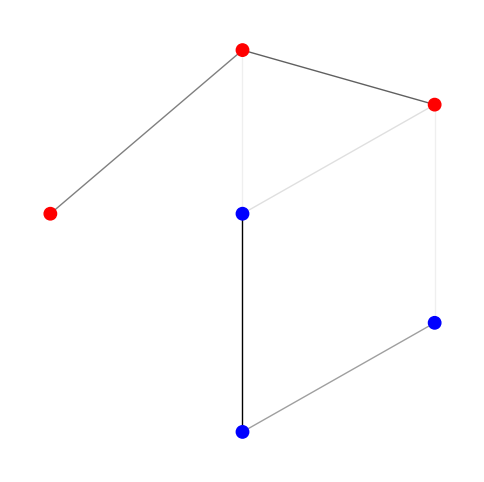

In [9]:
nc = result_to_colors(G,sampleset.first.sample)
print_graph(G, node_color=nc)

In [10]:
print(Q)

[[-4.40000000e+01  8.80000000e+01 -7.19318182e+00  0.00000000e+00
   3.10227273e+00  0.00000000e+00  1.51136364e+00  0.00000000e+00
   4.75000000e+00  0.00000000e+00 -6.27272727e+00  0.00000000e+00]
 [ 0.00000000e+00 -4.40000000e+01  0.00000000e+00 -7.19318182e+00
   0.00000000e+00  3.10227273e+00  0.00000000e+00  1.51136364e+00
   0.00000000e+00  4.75000000e+00  0.00000000e+00 -6.27272727e+00]
 [ 0.00000000e+00  0.00000000e+00 -4.40000000e+01  8.80000000e+01
   8.06818182e-01  0.00000000e+00  3.40909091e-02  0.00000000e+00
   3.25000000e+00  0.00000000e+00  1.18181818e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.40000000e+01
   0.00000000e+00  8.06818182e-01  0.00000000e+00  3.40909091e-02
   0.00000000e+00  3.25000000e+00  0.00000000e+00  1.18181818e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -4.40000000e+01  8.80000000e+01  1.51136364e+00  0.00000000e+00
  -1.12500000e+01  0.00000000e+00  1.72727273e+00  0.00000000e+00]
 [ 0.

### Heuristic solver

In [11]:
num_reads = 1000
ts = time.time()
sampleset = SimulatedAnnealingSampler().sample(bqm, num_reads=num_reads)
det_time = (time.time()-ts)*1000
print('Time used (ms): {:.3f}\n'.format(det_time))
print('Lowest energy was:',int(sampleset.first.energy))

Time used (ms): 116.433

Lowest energy was: -290


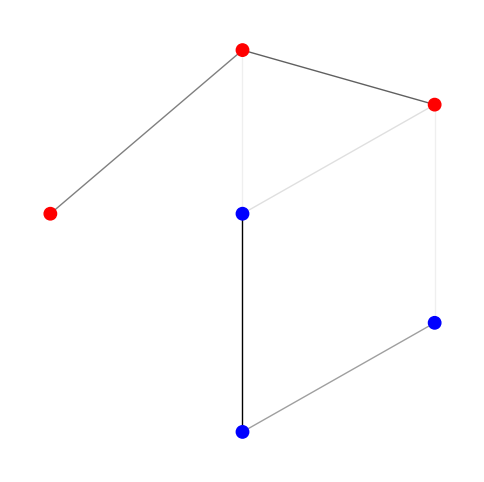

In [12]:
nc = result_to_colors(G,sampleset.first.sample)
print_graph(G, node_color=nc)

### Quantum solver

In [13]:
machine = DWaveSampler(solver={'chip_id': 'Advantage_system4.1'})
print('Chip:', machine.properties['chip_id'])
print('Qubits:', machine.properties['num_qubits'])

print('\nNumber of logical qubits needed:',Q.shape[0])
print('Number of couplers needed:', len(bqm.quadratic))
print('Default annealing time:',machine.properties["default_annealing_time"])  

Chip: Advantage_system4.1
Qubits: 5760

Number of logical qubits needed: 12
Number of couplers needed: 36
Default annealing time: 20.0


In [14]:
num_reads = 1000
sampleset = EmbeddingComposite(machine).sample(bqm, num_reads=num_reads)

In [15]:
qpu_time = sampleset.info['timing']['qpu_access_time'] / 1000
qubits = sum(len(x) for x in sampleset.info['embedding_context']['embedding'].values())
print('QPU time used (ms): {:.1f}'.format(qpu_time))
print('Physical qubits used: {}\n'.format(qubits))
print('Lowest energy was:',int(sampleset.first.energy))

QPU time used (ms): 116.5
Physical qubits used: 16

Lowest energy was: -290


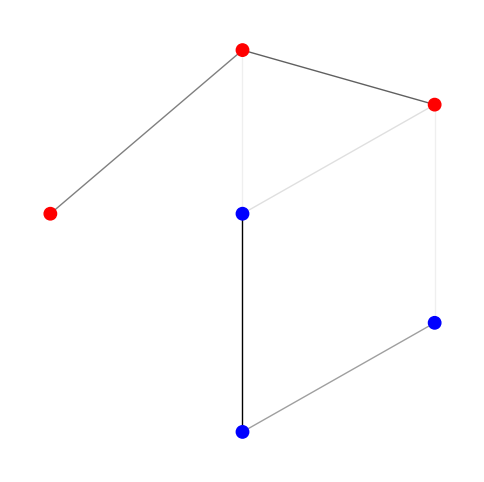

In [16]:
nc = result_to_colors(G,sampleset.first.sample)
print_graph(G, node_color=nc)

### Hybrid solver

QPU time used (ms): 150.9
Total time used (ms): 2990.0



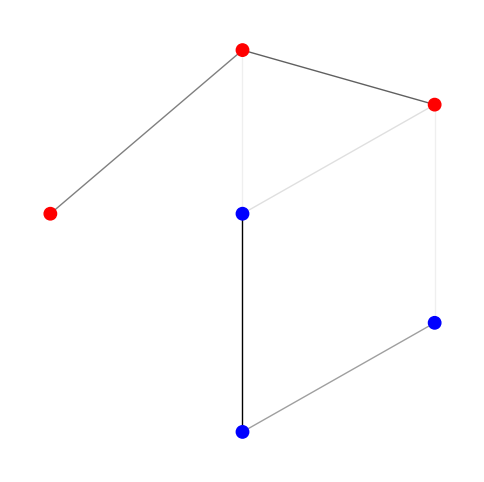

In [17]:
sampleset = LeapHybridSampler().sample(bqm)
hyb_time = sampleset.info['qpu_access_time'] / 1000
run_time = sampleset.info['run_time'] / 1000
print('QPU time used (ms): {:.1f}'.format(hyb_time))
print('Total time used (ms): {:.1f}\n'.format(run_time))
nc = result_to_colors(G,sampleset.first.sample)
print_graph(G, node_color=nc)

## More complex matrix

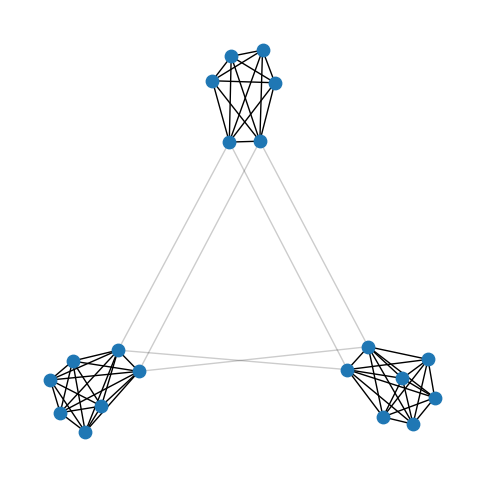

Number of edges: 63
Number of vertices: 20


In [18]:
seed = 42
communities = 4
vertices = 20
random.seed(seed)
G = create_community_graph(vertices,3)
# G = nx.relaxed_caveman_graph(communities,20,0.05)
# G = nx.random_geometric_graph(40, 0.25, seed=seed)
print_graph(G, pos=nx.spring_layout(G))
#print_graph(G)
print('Number of edges:',len(G.edges))
print('Number of vertices:',len(G.nodes))

In [19]:
max_count = 0
for e in G.edges:
    max_count += G[e[0]][e[1]]['weight']
print('Max count:',max_count)

labels = {}
for i in range(len(G.nodes)):
    for j in range(communities):
        labels[i*communities + j]=(i,j)

Max count: 291


### Create QUBO and BQM

In [20]:
ts = time.time()
Q = create_qubo(G, communities, max_count)
qubo_time = (time.time()-ts)*1000
print('Time used for construction Q (ms): {:.3f}\n'.format(qubo_time))

ts = time.time()
bqm = dimod.BinaryQuadraticModel(Q, 'BINARY')
bqm_time = (time.time()-ts)*1000
bqm = bqm.relabel_variables(labels, inplace=False)

Time used for construction Q (ms): 1.009



### Heuristic solver

In [21]:
num_reads = 2000
ts = time.time()
sampleset = SimulatedAnnealingSampler().sample(bqm, num_reads=num_reads)
det_time = (time.time()-ts)*1000
print('Time used (ms): {:.3f}\n'.format(det_time))
print('Lowest energy was:',int(sampleset.first.energy))

Time used (ms): 1676.999

Lowest energy was: -5905


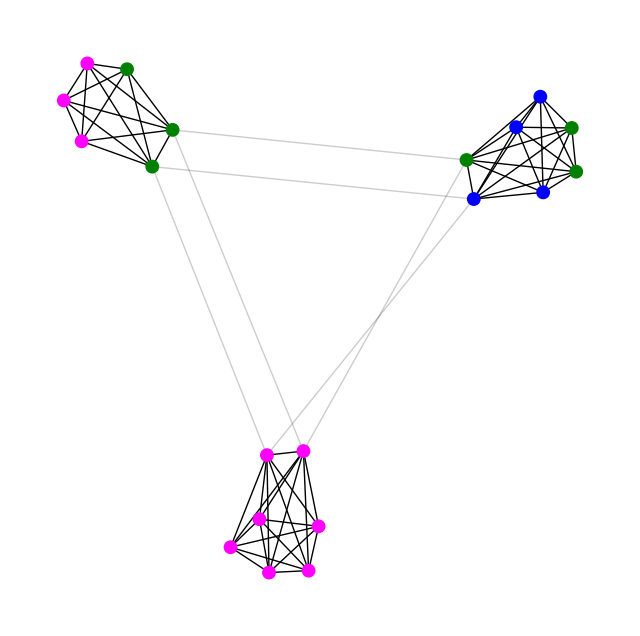

In [22]:
nc = result_to_colors(G,sampleset.first.sample)
print_graph(G, node_color=nc, pos=nx.spring_layout(G), fig_size=8)

In [23]:
c2 = [[] for i in range(communities)]
for k,v in sampleset.first.sample.items():
    if v==1:
        c2[k[1]].append(k[0])
c2 = [frozenset(x) for x in c2]
print(nx.community.is_partition(G, c2))
print(c2)

True
[frozenset({1, 2, 5, 6}), frozenset(), frozenset({0, 3, 4, 14, 15, 16}), frozenset({7, 8, 9, 10, 11, 12, 13, 17, 18, 19})]


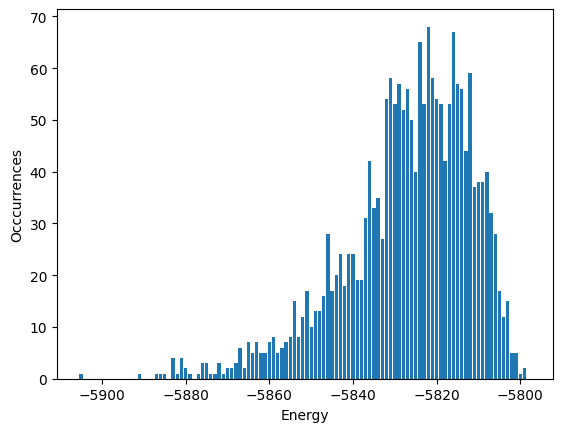

In [24]:
data = {}
maxv = int(sampleset.first.energy)
minv = int(sampleset.first.energy)
for e,n in sampleset.data(fields=['energy','num_occurrences']):
    energy = int(e)
    minv = min(energy,minv)
    maxv = max(energy,maxv)
    if energy in data.keys():
        data[energy] += n
    else:
        data[energy] = n
labels = []
datap = []
for i in range(minv,maxv):
    labels.append(i)
    if i in data.keys():
        datap.append(data[i])
    else:
        datap.append(0)
plt.bar(labels,datap)
plt.xlabel('Energy')
plt.ylabel('Occcurrences')
plt.show()

### Quantum Solver

In [25]:
machine = DWaveSampler(solver={'chip_id': 'Advantage_system4.1'})
print('Chip:', machine.properties['chip_id'])
print('Qubits:', machine.properties['num_qubits'])

print('\nNumber of logical qubits needed:',Q.shape[0])
print('Number of couplers needed:', len(bqm.quadratic))
print('Default annealing time:',machine.properties["default_annealing_time"])   

Chip: Advantage_system4.1
Qubits: 5760

Number of logical qubits needed: 80
Number of couplers needed: 880
Default annealing time: 20.0


Chain strength: https://www.dwavesys.com/media/qvbjrzgg/guide-2.pdf

In [26]:
annealing_time = 20 # Default 20
num_reads = 2000
sampleset = EmbeddingComposite(machine).sample(bqm, num_reads=num_reads, annealing_time=annealing_time)

In [27]:
qpu_time = sampleset.info['timing']['qpu_access_time'] / 1000
qubits = sum(len(x) for x in sampleset.info['embedding_context']['embedding'].values())
print('QPU time used (ms): {:.1f}'.format(qpu_time))
print('Physical qubits used: {}\n'.format(qubits))
print('Lowest energy was:',int(sampleset.first.energy))

QPU time used (ms): 367.0
Physical qubits used: 501

Lowest energy was: -5883


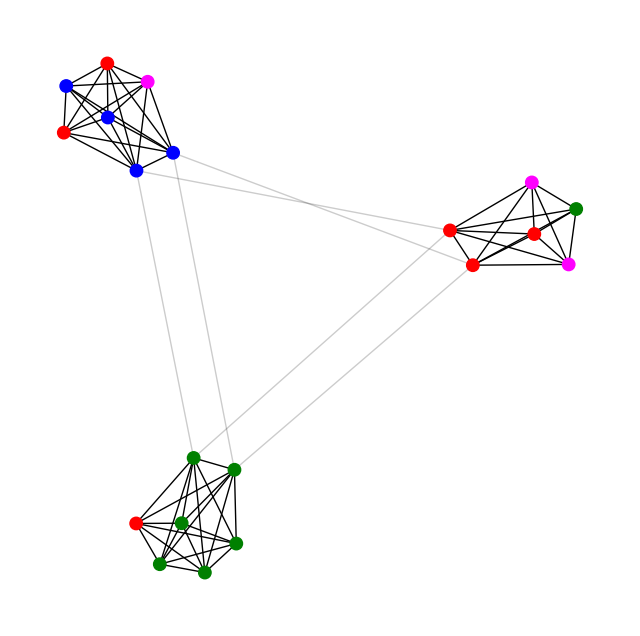

0.0


In [28]:
nc = result_to_colors(G,sampleset.first.sample)
print_graph(G, node_color=nc, pos=nx.spring_layout(G), fig_size=8)
print(sampleset.first.chain_break_fraction)

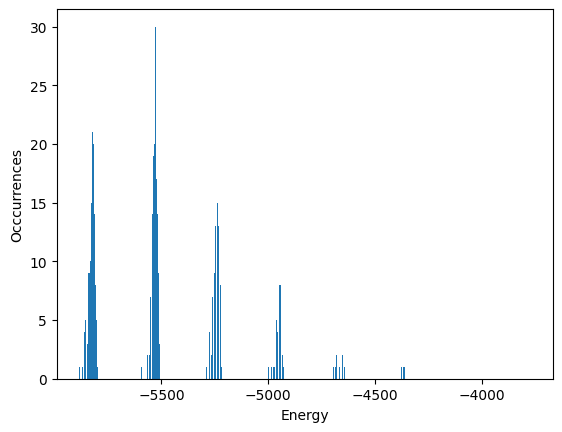

In [29]:
data = {}
maxv = int(sampleset.first.energy)
minv = int(sampleset.first.energy)
for e,n in sampleset.data(fields=['energy','num_occurrences']):
    energy = int(e)
    minv = min(energy,minv)
    maxv = max(energy,maxv)
    if energy in data.keys():
        data[energy] += n
    else:
        data[energy] = n
labels = []
datap = []
for i in range(minv,maxv):
    labels.append(i)
    if i in data.keys():
        datap.append(data[i])
    else:
        datap.append(0)
plt.bar(labels,datap)
plt.xlabel('Energy')
plt.ylabel('Occcurrences')
plt.show()

In [30]:
dwave.inspector.show(sampleset)

Serving Inspector on http://127.0.0.1:18000/?problemId=926769c4-501a-4e2a-8beb-55c9e85ea7cd

'http://127.0.0.1:18000/?problemId=926769c4-501a-4e2a-8beb-55c9e85ea7cd'

### HYbdrid solver

QPU time used (ms): 33.7
Total time used (ms): 2993.1



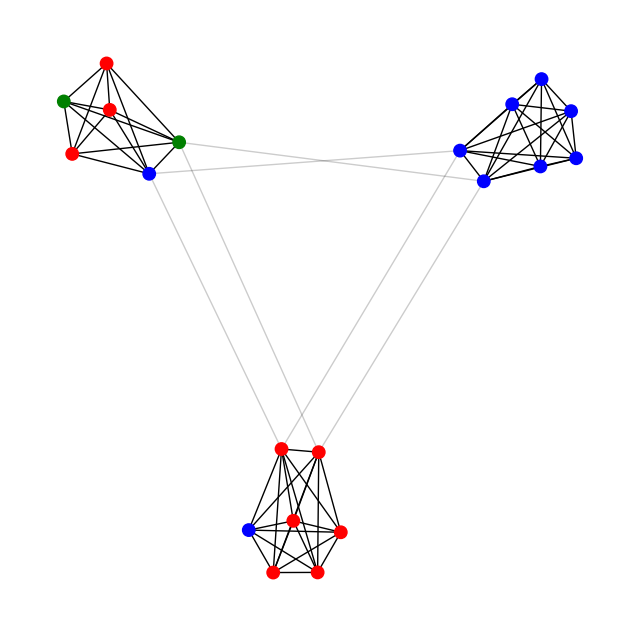

In [31]:
sampleset = LeapHybridSampler().sample(bqm)
hyb_time = sampleset.info['qpu_access_time'] / 1000
run_time = sampleset.info['run_time'] / 1000
print('QPU time used (ms): {:.1f}'.format(hyb_time))
print('Total time used (ms): {:.1f}\n'.format(run_time))
nc = result_to_colors(G,sampleset.first.sample)
print_graph(G, node_color=nc, pos=nx.spring_layout(G), fig_size=8)

## More examples

In [34]:
def solve_random_graph(size, communities=4, fig_size=6):
    max_weight = 10
    random.seed(seed)
    G = create_community_graph(size,3)
    nx.set_edge_attributes(G, {e: {'weight': random.randint(1, max_weight)} for e in G.edges})
    
    max_count = 0
    for e in G.edges:
        max_count += G[e[0]][e[1]]['weight']

    labels = {}
    for i in range(len(G.nodes)):
        for j in range(communities):
            labels[i*communities + j]=(i,j)
            
    Q = create_qubo(G, communities, max_count)
    bqm = dimod.BinaryQuadraticModel(Q, 'BINARY')
    bqm = bqm.relabel_variables(labels, inplace=False) 
    
    print('\nNumber of logical qubits needed:',Q.shape[0])
    print('Number of couplers needed:', len(bqm.quadratic))
    print('\nSimulator solver')
    num_reads = 1000
    ts = time.time()
    sampleset = SimulatedAnnealingSampler().sample(bqm, num_reads=num_reads)
    det_time = (time.time()-ts)*1000
    print('Time used (ms): {:.3f}\n'.format(det_time))
    nc = result_to_colors(G,sampleset.first.sample)
    print_graph(G, node_color=nc, fig_size=fig_size, pos=nx.spring_layout(G))
    
    print('Hybrid solver')
    sampleset = LeapHybridSampler().sample(bqm)
    hyb_time = sampleset.info['qpu_access_time'] / 1000
    run_time = sampleset.info['run_time'] / 1000
    print('QPU time used (ms): {:.1f}'.format(hyb_time))
    print('Total time used (ms): {:.1f}\n'.format(run_time))
    nc = result_to_colors(G,sampleset.first.sample)
    print_graph(G, node_color=nc, pos=nx.spring_layout(G))


Number of logical qubits needed: 120
Number of couplers needed: 1920

Simulator solver
Time used (ms): 1108.365



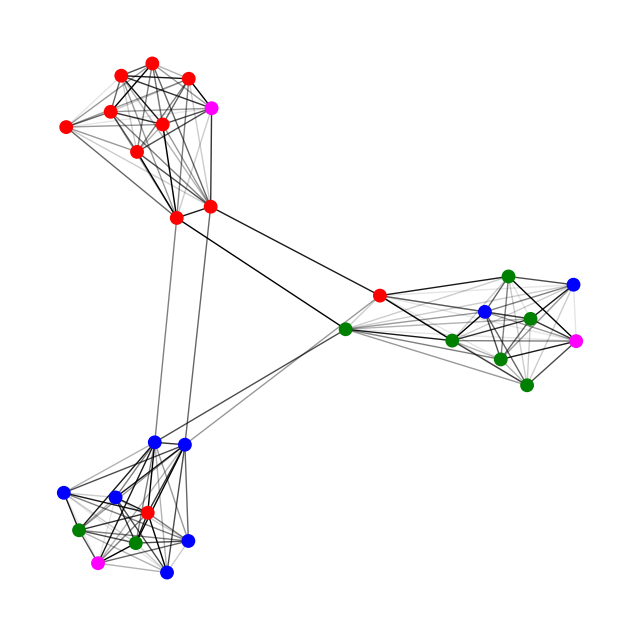

Hybrid solver
QPU time used (ms): 113.8
Total time used (ms): 2991.0



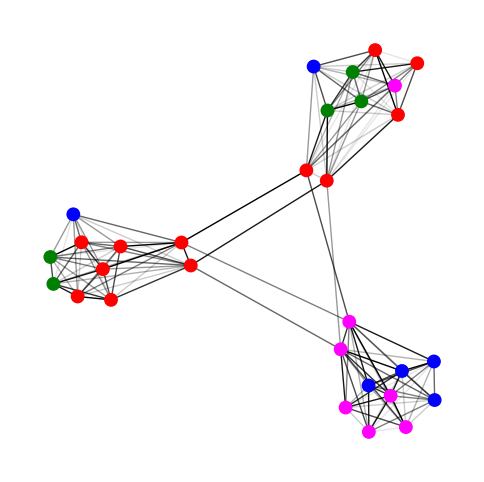

In [35]:
solve_random_graph(30, fig_size=8)


Number of logical qubits needed: 160
Number of couplers needed: 3360

Simulator solver
Time used (ms): 1503.116



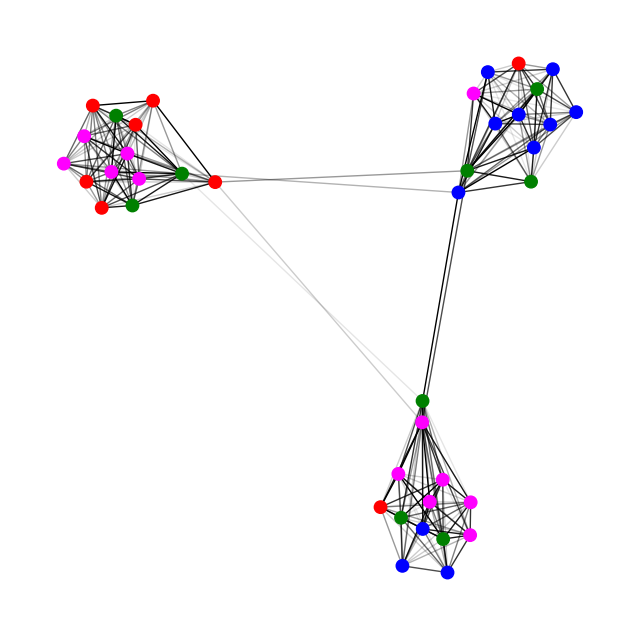

Hybrid solver
QPU time used (ms): 78.4
Total time used (ms): 2987.2



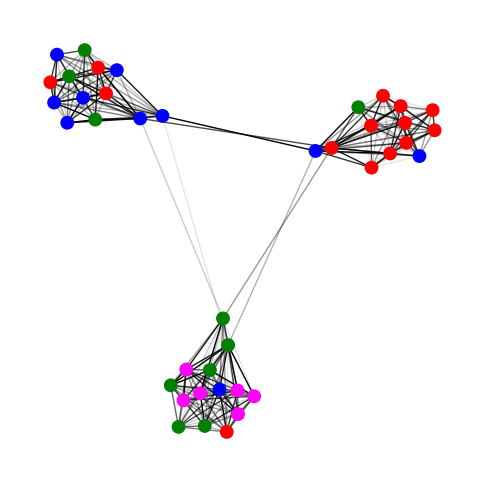

In [36]:
solve_random_graph(40, communities=4, fig_size=8)